# Dimensionality Reduction (PCA)

The primary purpose of this exercise is to implement PCA from scratch and without prepared functions in sklearn.

Then we want to compare and analyze results after and before dimensionality reduction.

## Dataset

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import imutils

Brain Tumor dataset is attached to the notebook. It has two folders (yes and no).

'yes' folder contains MRI images of patients with Tumor and 'no' folder contains images of healthy people.

<font color='blue'  size=3>
Note: We wish no one would be in 'yes' folder in real life.


## Preprocess

In [4]:
### Cropping is a suggested tool for preprocessing this dataset

import cv2
import os
import numpy as np
import imutils

def crop_brain(image):
    # Convert the image to grayscale and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    if len(cnts) == 0:
        return image  # If no contours are found, return original image

    c = max(cnts, key=cv2.contourArea)
    
    # Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop new image using the four extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    
    return new_image

## Load data

In [ ]:
from sklearn.utils import shuffle
IMG_WIDTH, IMG_HEIGHT = (128,128)
DATASET_PATH = "BrainTumor"  # Adjust this path accordingly
#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  load data (use cv2) then crop (use function above) and after that resize each image to (128,128) then change it to
#  one channel image (gray scale not RGB)
#  assign lablel 1 for patients with tumor and 0 otherwise
#####################################################################################
categories = ["yes", "no"]

X = []  # Image data
y = []  # Labels

for category in categories:
    path = os.path.join(DATASET_PATH, category)
    label = 1 if category == "yes" else 0  # Assign labels

    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        image = cv2.imread(img_path)
        
        if image is None:
            continue  # Skip if image is not read properly
        
        # Process image
        cropped = crop_brain(image)  # Crop brain
        resized = cv2.resize(cropped, (128, 128))  # Resize to (128, 128)
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

        X.append(gray)
        y.append(label)

####################################################################################
#                                   THE END                                        #
####################################################################################
X = np.array(X, dtype="float32") / 255.0  # Normalize pixel values
y = np.array(y)
#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  shuffle data (becareful about labels)
#####################################################################################
X, y = shuffle(X, y, random_state=42)
####################################################################################
#                                   THE END                                        #
####################################################################################


In [7]:
#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  show number of example and x , y size
#####################################################################################
print(f"Number of examples is: {len(X)}")
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
####################################################################################
#                                   THE END                                        #
####################################################################################

Number of examples is: 253
X shape is: (253, 128, 128)
y shape is: (253,)


## Flatten

Reshape X so that each row represents one image or 128*128 pixels (2D data)

In [8]:
#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  Reshape X to (number_of_example, number_of_all_pixels)
#####################################################################################
X = X.reshape(X.shape[0], 128 * 128)

print(f"Reshaped X shape: {X.shape}")
####################################################################################
#                                   THE END                                        #
####################################################################################

Reshaped X shape: (253, 16384)


## Split
In this section, split dataset to train and test and you can use splitting function from sklearn.

In [9]:
from sklearn.model_selection import train_test_split

#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  Split data to train and test (testsize = 0.2)
#####################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
####################################################################################
#                                   THE END                                        #
####################################################################################


X_train shape: (202, 16384)
X_test shape: (51, 16384)
y_train shape: (202,)
y_test shape: (51,)


## PCA

Implement PCA. Then use it to project the data to the latent space.  Note that you should implement the PCA, so using existing libraries is not allowed. you should use numpy to compute eigenvectors/eigenvalues or SVD of a matrix.

It is highly recommended to use svd function from linalg instead of eig or eigh.

### Fit function

In [10]:
def fit_PCA(X, n_components):
    #####################################################################################
    #                          COMPLETE THE FOLLOWING SECTION                           #
    #####################################################################################
    # X: a vector of shape (N, M)
    # n_components: size of latent space (< M)
    # returns a vector of shape (n_components, M) containing the first `n_components` PCs and mean of data
    #####################################################################################
    # Compute the mean of the data (per feature)
    mean = np.mean(X, axis=0)
    # Center the data
    X_centered = X - mean
    # Perform SVD on the centered data
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    # Select the first n_components principal components (rows of Vt)
    components = Vt[:n_components, :]
    return components, mean
    ####################################################################################
    #                                   THE END                                        #
    ####################################################################################


### Transform function

In [11]:
def transform_PCA(X, mean, components):
    projected_data = None
    #####################################################################################
    #                          COMPLETE THE FOLLOWING SECTION                           #
    #####################################################################################
    # X: a vector of shape (N, M)
    # mean : a vector of shape (M,)
    # components: a vector of shape (n_components, M)
    # returns projected data of shape (N, n_comonents)
    #####################################################################################
    # Center the data using the computed mean
    X_centered = X - mean
    # Project the centered data onto the principal components
    projected_data = np.dot(X_centered, components.T)
    return projected_data
    ####################################################################################
    #                                   THE END                                        #
    ####################################################################################

### Reconstruction function


In [14]:
def reconstruct_PCA(X, mean, components):
    reconstructed_data = None
    #####################################################################################
    #                          COMPLETE THE FOLLOWING SECTION                           #
    #####################################################################################
    # X: a vector of shape (N, n_comonents)
    # mean : a vector of shape (M,)
    # components: a vector of shape (n_components, M)
    # returns reconstructed data of shape (N, M)
    #####################################################################################
    # Reconstruct data by projecting back to the original space and adding the mean
    reconstructed_data = np.dot(X, components) + mean
    return reconstructed_data
    ####################################################################################
    #                                   THE END                                        #
    ####################################################################################

We have 3 choices here:

*   Fit the model with X and apply the dimensionality reduction on X_train and X_test.
*   Fit the model with X_train and apply the dimensionality reduction on X_train and X_test.

*   Fit and apply the dimensionality reduction on X_train separately from  X_test.


Based on class lectures, choose of one these choices and explain why.

- **Avoiding Information Leakage**:<br>
  By fitting PCA only on the training data (X_train), you ensure that no information from the test set influences the learned components. Fitting on the entire dataset (X) would leak information from the test set into your transformation, which can lead to overly optimistic performance estimates.

- **Consistency in Transformation**:<br>
  When you transform both X_train and X_test using the PCA components derived solely from X_train, you maintain a 
  consistent transformation across both datasets. This is crucial because the model should be evaluated on data that has been processed in the same way as the training data.

- **Realistic Scenario**:<br>
  In real-world applications, new data (analogous to X_test) is unseen during model training. Fitting PCA on only 
  the training set simulates this scenario, ensuring that your dimensionality reduction step generalizes well to 
  new, unseen data.

`Thus, the second choice is the correct one.`

Fill the bottom cell according to your choice. We have set the reduced dimension = 20.

---



In [12]:
n_components = 20
X_train_red = None
X_test_red = None
#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  reduce the dimensions of X_train and X_test to 20
#####################################################################################
# Fit PCA on X_train
components, mean = fit_PCA(X_train, n_components)

# Transform both training and test sets using the learned PCA components and mean
X_train_red = transform_PCA(X_train, mean, components)
X_test_red = transform_PCA(X_test, mean, components)

print("X_train_red shape:", X_train_red.shape)
print("X_test_red shape:", X_test_red.shape)

####################################################################################
#                                   THE END                                        #
####################################################################################

X_train_red shape: (202, 20)
X_test_red shape: (51, 20)


## Reconstruction

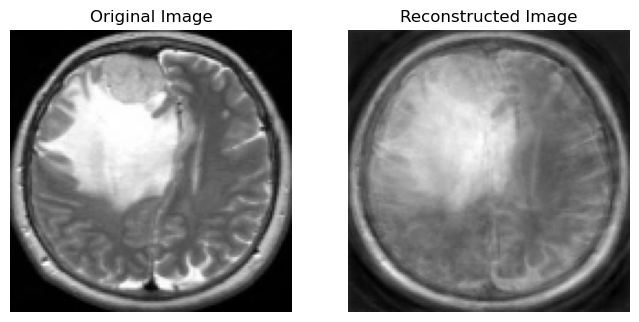

In [19]:
import matplotlib.pyplot as plt
import random

#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  Reconstruct One random row of X_train and reshape to (128,128) and plot it
#  Then compare it to the original one
#  It is better to use gray cmap for images
#####################################################################################

# Choose a random index
random_idx = random.randint(0, X_train.shape[0] - 1)

# Get the corresponding row in reduced space
X_train_sample = X_train_red[random_idx].reshape(1, -1)  # Ensure it's a row vector

# Reconstruct the image
X_reconstructed = reconstruct_PCA(X_train_sample, mean, components)

# Reshape back to (128, 128)
original_image = X_train[random_idx].reshape(128, 128)
reconstructed_image = X_reconstructed.reshape(128, 128)

# Plot original and reconstructed images side by side
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis("off")

plt.show()

####################################################################################
#                                   THE END                                        #
####################################################################################


# Classifier

In this section use Support Vector Machine (SVM) for predicting Tumor from features.


Our purpose is comparing accuracy on test data before and after dimensionality reduction. Guess for yourself accuracy before and after PCA.

Typically, we might expect a small drop in performance after PCA when the reduction is significant. However, if most of the variance is preserved in the top 20 components, the accuracy may remain similar.

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
model =  SVC(kernel='linear')

## Before dimensionality reduction

In [ ]:
before_accuracy = None
#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  Train model on X_train and report accuracy on X_test
#####################################################################################
# Train SVM on original features
model.fit(X_train, y_train)
# Predict on test data
y_pred_before = model.predict(X_test)
# Compute accuracy on test data
before_accuracy = accuracy_score(y_test, y_pred_before)
print("Test Accuracy before PCA:", before_accuracy)
####################################################################################
#                                   THE END                                        #
####################################################################################


Test Accuracy before PCA: 0.803921568627451


## After dimensionality reduction

In [22]:
after_accuracy = None
#####################################################################################
#                          COMPLETE THE FOLLOWING SECTION                           #
#####################################################################################
#  Train model on X_train_red and report accuracy on X_test_red
#####################################################################################
# Train SVM on the dimensionally reduced training data
model.fit(X_train_red, y_train)
# Predict on PCA-reduced test data
y_pred_after = model.predict(X_test_red)
# Compute accuracy on test data
after_accuracy = accuracy_score(y_test, y_pred_after)
print("Test Accuracy after PCA:", after_accuracy)
####################################################################################
#                                   THE END                                        #
####################################################################################

Test Accuracy after PCA: 0.6470588235294118


When you get better accuracy?

 Can you explain why?

 Does unsupervised dimensionality reduction always increase accuracy?


You might observe better accuracy after applying PCA `when the original data contains a lot of noise` or redundant features. In such cases, PCA helps by compressing the data to retain only the most significant variance, which often corresponds to the most informative features for classification. This noise reduction and feature extraction can improve generalization and, consequently, accuracy on unseen test data.

However, unsupervised dimensionality reduction like `PCA does not always increase accuracy`. Since PCA is unsupervised, it selects components based solely on variance, not on how well features discriminate between classes. This means that if the directions of highest variance don't align with the features that best separate the classes, PCA might discard useful information, potentially reducing classification performance.